# **I. Mise en place et chargement des données**

In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import random
from tqdm import tqdm

# Fixer des seeds aléatoires pour la reproductibilité
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Vérifier si un GPU est disponbible :
# Vérifier si CUDA (GPU NVIDIA) ou MPS (Apple Silicon) est disponbible :
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [15]:
# Renommer les images capturées

# for action in ['LEFT', 'RIGHT', 'FIRE', 'ENTER'] :

  #  dossier_cible = f"Echantillons/{action}"  # Dossier dont renommer les images

   # images = os.listdir(dossier_cible)

   # for i, image in enumerate(images):
    #    os.rename(os.path.join(dossier_cible, image), os.path.join(dossier_cible, f"{action}_{i}.jpg"))

# print("Images renommées !")

In [16]:
# Pour travailler sur Google Colab si l'échantillon est dans Google Drive

# from google.colab import drive
# drive.mount('/content/drive')
# dataset_path = "/content/drive/My Drive/Echantillons"  

In [17]:
dataset_path = 'Echantillons'

# Définir les transformations des images (redimensionnement et normalisation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionne les images
    transforms.ToTensor(), # Convertit en tenseur PyTorch
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Normalise
])

# Charger les images depuis les dossiers
dataset = datasets.ImageFolder(root = dataset_path, transform = transform, is_valid_file = lambda x: x.endswith(('.jpg')))

# Vérifier les classes détectées
print("Classes détectées :", dataset.classes)

# Séparer en train et test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Création des DataLoaders
trainloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2)
testloader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 2)

print("Dataloaders prêts !")

Classes détectées : ['ENTER', 'FIRE', 'LEFT', 'RIGHT']
Dataloaders prêts !


In [18]:
## Classes :

# 0 = 'ENTER'
# 1 = 'FIRE'
# 2 = 'LEFT'
# 3 = 'RIGHT'

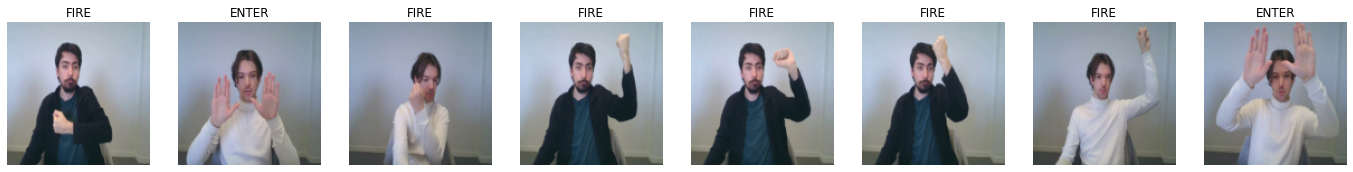

In [19]:
# Fonction pour afficher les images avec leur label
def imshow(images, labels):

    images = images.numpy().transpose((0, 2, 3, 1))  # Convertir pour affichage (batch, hauteur, largeur, canal)
    images = images * 0.229 + 0.485  # Dé-normalisation
    images = np.clip(images, 0, 1)  # S'assurer que les valeurs restent dans [0,1]

    # Nombre d'images à afficher
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    if num_images == 1:
        axes = [axes]  # Pour éviter une erreur avec une seule image

    # Affichage des images avec les labels en titre
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(dataset.classes[labels[i]])  # Affichage du label comme titre
        ax.axis("off")

    plt.show()

# Récupérer un batch d'images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Afficher les premières 8 images avec leurs labels
imshow(images[:8], labels[:8])

# **II. Analyse des données**

Nombre d'images dans l'échantillon d'entraînement: 4184
Nombre d'images dans l'échantillon de test : 1046
Dimensions des images : 128 x 128 avec 3 canaux RGB.
Classe 'FIRE': 1999 images
Classe 'ENTER': 983 images
Classe 'LEFT': 784 images
Classe 'RIGHT': 1464 images


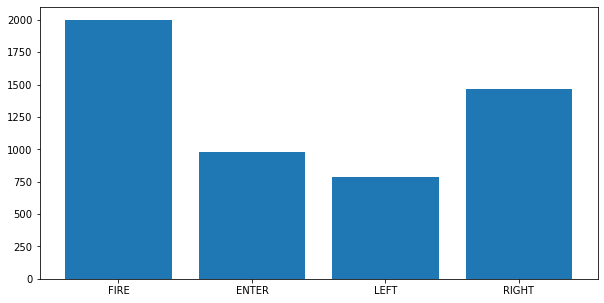

In [27]:
def analyze_dataset(trainset, testset, classes):

    # 1. Récupérer le total d'images
    print(f"Nombre d'images dans l'échantillon d'entraînement: {len(trainset)}")
    print(f"Nombre d'images dans l'échantillon de test : {len(testset)}")

    # 2. Récupérer les dimensions des images
    print(f"Dimensions des images : {trainset[0][0].shape[1]} x {trainset[0][0].shape[2]} avec {trainset[0][0].shape[0]} canaux RGB.")

    # 3. Compter le nombre d'images par classe dans le jeu de données
    # Dictionnaire pour stocker le nombre d'images par classe
    class_counts = {}
    # Parcourir chaque dossier (chaque classe)
    for class_name in os.listdir(dataset_path):
      class_path = os.path.join(dataset_path, class_name)
      # Vérifier que c'est bien un dossier
      if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = num_images
    # Afficher le nombre d'images par classe
    for class_name, count in class_counts.items():
      print(f"Classe '{class_name}': {count} images")

    # 4. Visualiser la distribution des classes dans le jeu de données
    plt.figure(figsize=(10, 5))
    plt.bar(class_counts.keys(), class_counts.values())

# Appeler la fonction pour analyser le jeu de données
analyze_dataset(train_dataset, test_dataset, dataset.classes)

# **III. Augmentation des données**

In [21]:
def get_augmentation_transforms():

    augmentation_transforms = transforms.Compose([
        transforms.Resize((128, 128)),  # Redimensionne les images
        transforms.ToTensor(), # Convertit en tenseurs
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]), # Normalise
        transforms.RandomRotation(degrees = 15), # Rotation aléatoire de 15 degrés
        transforms.ColorJitter(1) # Modification aléatoire de la luminosité

    ])

    return augmentation_transforms

# Création d'un nouveau jeu de données avec augmentation :

augmentation_transforms = get_augmentation_transforms()
# Charger les images depuis les dossiers
augmented_dataset = datasets.ImageFolder(root = dataset_path, transform = augmentation_transforms, is_valid_file = lambda x: x.endswith(('.jpg')))
# Séparer en train et test
augmented_train_dataset, augmented_test_dataset = random_split(augmented_dataset, [train_size, test_size])
# Création des DataLoaders
augmented_trainloader = DataLoader(augmented_train_dataset, batch_size = 32, shuffle = True, num_workers = 2)

print("Dataloaders prêts !")

Dataloaders prêts !


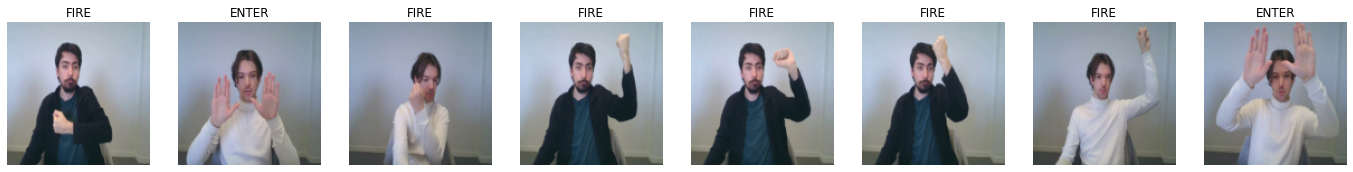

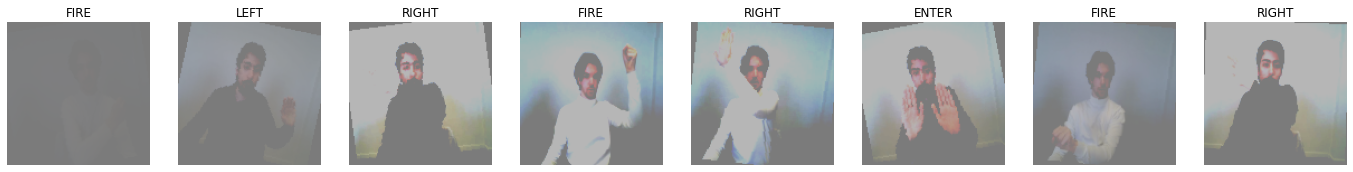

In [22]:
# Récupération d'images d'entraînement augmentées
augmented_dataiter = iter(augmented_trainloader)
augmented_images, augmented_labels = next(augmented_dataiter)

# Affichage des images originales avec leurs labels :
imshow(images[:8], labels[:8])

# Affiche des images augmentées :
# Récupérer un batch d'images augmentées
augmented_dataiter = iter(augmented_trainloader)
augmented_images, augmented_labels = next(augmented_dataiter)
# Afficher les premières 8 images avec leurs labels
imshow(augmented_images[:8], augmented_labels[:8])

# **IV. Construction d'un CNN simple**

In [23]:
# Réseau de neurone convolutionnel simple
class SimpleCNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size = 3, stride = 1, padding = 1) # 3x128x128 -> 1x128x128
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2) # 1x128x128 -> 1x64x64
        self.fc1 = nn.Linear(64 * 64, num_classes) # 1x64x64 -> 4

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 64 * 64)
        x = F.relu(self.fc1(x))
        return x

# Créer une instance du modèle
model = SimpleCNN(num_classes = 4).to(device)
print(model)

# Inférer une image avec le modèle
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images.to(device)
image = images[0]
print(f"Dimension de l'image : {image.shape[1]} x {image.shape[2]} avec {image.shape[0]} caneaux RGB.")
outputs = model(image)
print(f"Prédiction de dimension : {outputs.shape[1]}.")
print(f"Prediction : {outputs}")

SimpleCNN(
  (conv1): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=4, bias=True)
)
Dimension de l'image : 128 x 128 avec 3 caneaux RGB.
Prédiction de dimension : 4.
Prediction : tensor([[0.0000, 0.0000, 0.0160, 0.1005]], grad_fn=<ReluBackward0>)


# **V. Entraînement du modèle**

In [24]:
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs = 5) :

    # Listes pour sauvegarder les métriques
    train_losses = []
    test_losses = []
    test_accuracies = []

    # Boucle d'entraînement
    for epoch in range(num_epochs) :

        # Phase d'entraînement
        model.train()
        running_loss = 0

        bar = tqdm(enumerate(trainloader, 0), total = len(trainloader))
        for i, data in bar :
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Phase d'évaluation
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0

        test_bar = tqdm(enumerate(testloader, 0), total = len(testloader))
        for i, data in test_bar:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

        # Afficher les métriques
        train_loss = running_loss / len(trainloader)
        test_loss = test_loss / len(testloader)
        test_acc = 100 * test_correct / test_total
        print(f'Epoch {epoch+1} / {num_epochs}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Test Acc: {test_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}')

        # Enregistrement des métriques
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

    return train_losses, test_losses, test_accuracies

# Définition de la fonction de perte et de l'optimisateur
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

# Lancement de l'entraînement du modèle
train_losses, test_losses, test_accuracies = train_model(
    model, augmented_trainloader, testloader, criterion, optimizer, num_epochs = 5)

100%|██████████| 33/33 [00:02<00:00, 15.81it/s]

Epoch 1 / 5, Train Loss: 1.3842, Test Acc: 24.19%, Test Loss: 1.4122



100%|██████████| 33/33 [00:02<00:00, 15.91it/s]

Epoch 2 / 5, Train Loss: 1.3725, Test Acc: 31.64%, Test Loss: 1.2775



100%|██████████| 33/33 [00:02<00:00, 14.36it/s]

Epoch 3 / 5, Train Loss: 1.2696, Test Acc: 51.24%, Test Loss: 1.5021



100%|██████████| 33/33 [00:02<00:00, 14.40it/s]

Epoch 4 / 5, Train Loss: 0.9530, Test Acc: 67.02%, Test Loss: 1.2559



100%|██████████| 33/33 [00:02<00:00, 13.90it/s]

Epoch 5 / 5, Train Loss: 0.6601, Test Acc: 65.20%, Test Loss: 3.2023


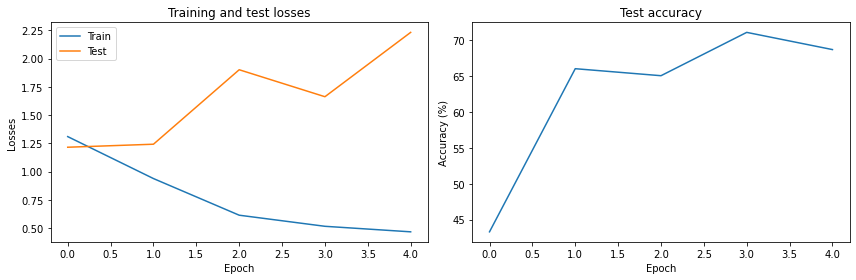

In [13]:
# Tracer les métriques d'entraînement et de test

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.title('Training and test losses')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')


plt.tight_layout()
plt.show()

# **VI. Amélioration du modèle**

In [25]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes = 4):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1) # 3x128x128 -> 16x128x128
        self.pool = nn.AvgPool2d(kernel_size = 2, stride = 2) # 16x128x128 -> 16x64x64
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1) # 16x64x64 -> 8x64x64
        self.fc1 = nn.Linear(8 * 64 * 64, 128) # 8x64x64 -> 128
        self.fc2 = nn.Linear(128, num_classes) # 128 -> 4
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = x.view(-1, 8 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the improved model
improved_model = ImprovedCNN(num_classes = 4).to(device)
print(improved_model)

# Define loss function and optimizer for the improved model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr = 0.001)

# Train the improved model
improved_train_losses, improved_train_accuracies, improved_test_accuracies = train_model(
    improved_model, augmented_trainloader, testloader, criterion, optimizer, num_epochs = 5)

ImprovedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


100%|██████████| 33/33 [00:02<00:00, 12.26it/s]

Epoch 1 / 5, Train Loss: 0.9323, Test Acc: 78.49%, Test Loss: 0.9547



100%|██████████| 33/33 [00:02<00:00, 12.63it/s]

Epoch 2 / 5, Train Loss: 0.3022, Test Acc: 92.83%, Test Loss: 0.3907



100%|██████████| 33/33 [00:02<00:00, 12.08it/s]

Epoch 3 / 5, Train Loss: 0.1917, Test Acc: 92.45%, Test Loss: 0.6530



100%|██████████| 33/33 [00:02<00:00, 11.68it/s]

Epoch 4 / 5, Train Loss: 0.1411, Test Acc: 90.44%, Test Loss: 1.1689



100%|██████████| 33/33 [00:02<00:00, 12.16it/s]

Epoch 5 / 5, Train Loss: 0.1083, Test Acc: 93.12%, Test Loss: 0.8370


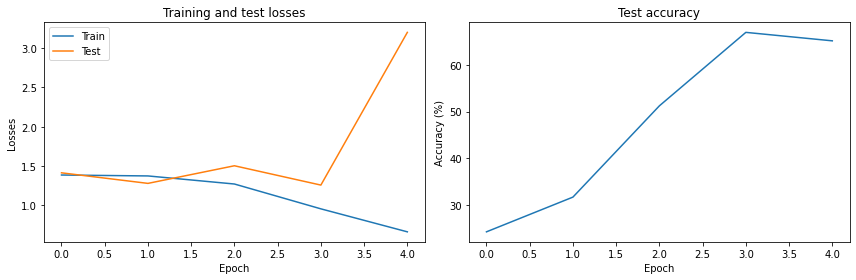

In [26]:
# Tracer les métriques d'entraînement et de test

plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.title('Training and test losses')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies)
plt.title('Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')


plt.tight_layout()
plt.show()